In [1]:
# For some reason Theano is unhappy when I run the GP, need to disable future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import sys
import requests
import pymc3 as pm
import pandas as pd
import numpy as np
import theano
import theano.tensor as tt

from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from matplotlib import ticker

from datetime import date
from datetime import datetime

from IPython.display import clear_output

%config InlineBackend.figure_format = 'retina'

In [2]:
SCRIPT_PATH='.'
module_path = os.path.abspath(os.path.join(SCRIPT_PATH))
if module_path not in sys.path:
    sys.path.append(module_path)

In [43]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
from utils import load_county_case_data, load_patient_data, get_delay_onset_confirmation_probabilities
from utils import prepare_county_cases, adjust_onset_for_right_censorship, confirmed_to_onset
from utils import create_and_run_model_for_counties, df_from_model, reparametrize
from utils import aggregate_results, plot_rt

# Strongly inspired by https://rt.live/

In [5]:
patients = load_patient_data()
patients = patients[(patients["Onset"] >= "2020-04-01")]
p_delay = get_delay_onset_confirmation_probabilities(patients)

In [7]:
patients.head()

,Confirmed,Onset
252542,2020-04-03,2020-04-01
252598,2020-04-03,2020-04-01
252629,2020-04-03,2020-04-02
252631,2020-04-03,2020-04-02
252696,2020-04-04,2020-04-01


In [53]:
county_cases = load_county_case_data()
county_cases = county_cases[county_cases["date"] >= "2020-04-01"]
county_cases.head()

,countyFIPS,county,state,stateFIPS,date,cases
223650,0,Statewide Unallocated,AL,1,2020-04-01,0.0
223651,1001,Autauga County,AL,1,2020-04-01,3.0
223652,1003,Baldwin County,AL,1,2020-04-01,4.0
223653,1005,Barbour County,AL,1,2020-04-01,0.0
223654,1007,Bibb County,AL,1,2020-04-01,0.0


In [38]:
ny_counties = county_cases[county_cases.state == "NY"]

In [39]:
ny_counties = ny_counties.set_index(ny_counties.date)
ny_counties.head()

,countyFIPS,county,state,stateFIPS,date,cases
date,,,,,,
2020-04-01,0,Statewide Unallocated,NY,36,2020-04-01,0.0
2020-04-01,1,New York City Unallocated/Probable,NY,36,2020-04-01,0.0
2020-04-01,36001,Albany County,NY,36,2020-04-01,14.0
2020-04-01,36003,Allegany County,NY,36,2020-04-01,2.0
2020-04-01,36005,Bronx County,NY,36,2020-04-01,793.0


In [40]:
ny_counties = ny_counties[ny_counties.county != "Statewide Unallocated"]
ny_counties = ny_counties[ny_counties.county != "New York City Unallocated/Probable"]

In [41]:
ny_counties.county.unique()

array(['Albany County', 'Allegany County', 'Bronx County',
       'Broome County', 'Cattaraugus County', 'Cayuga County',
       'Chautauqua County', 'Chemung County', 'Chenango County',
       'Clinton County', 'Columbia County', 'Cortland County',
       'Delaware County', 'Dutchess County', 'Erie County',
       'Essex County', 'Franklin County', 'Fulton County',
       'Genesee County', 'Greene County', 'Hamilton County',
       'Herkimer County', 'Jefferson County', 'Kings County',
       'Lewis County', 'Livingston County', 'Madison County',
       'Monroe County', 'Montgomery County', 'Nassau County',
       'New York County', 'Niagara County', 'Oneida County',
       'Onondaga County', 'Ontario County', 'Orange County',
       'Orleans County', 'Oswego County', 'Otsego County',
       'Putnam County', 'Queens County', 'Rensselaer County',
       'Richmond County', 'Rockland County', 'St. Lawrence County',
       'Saratoga County', 'Schenectady County', 'Schoharie County',
     

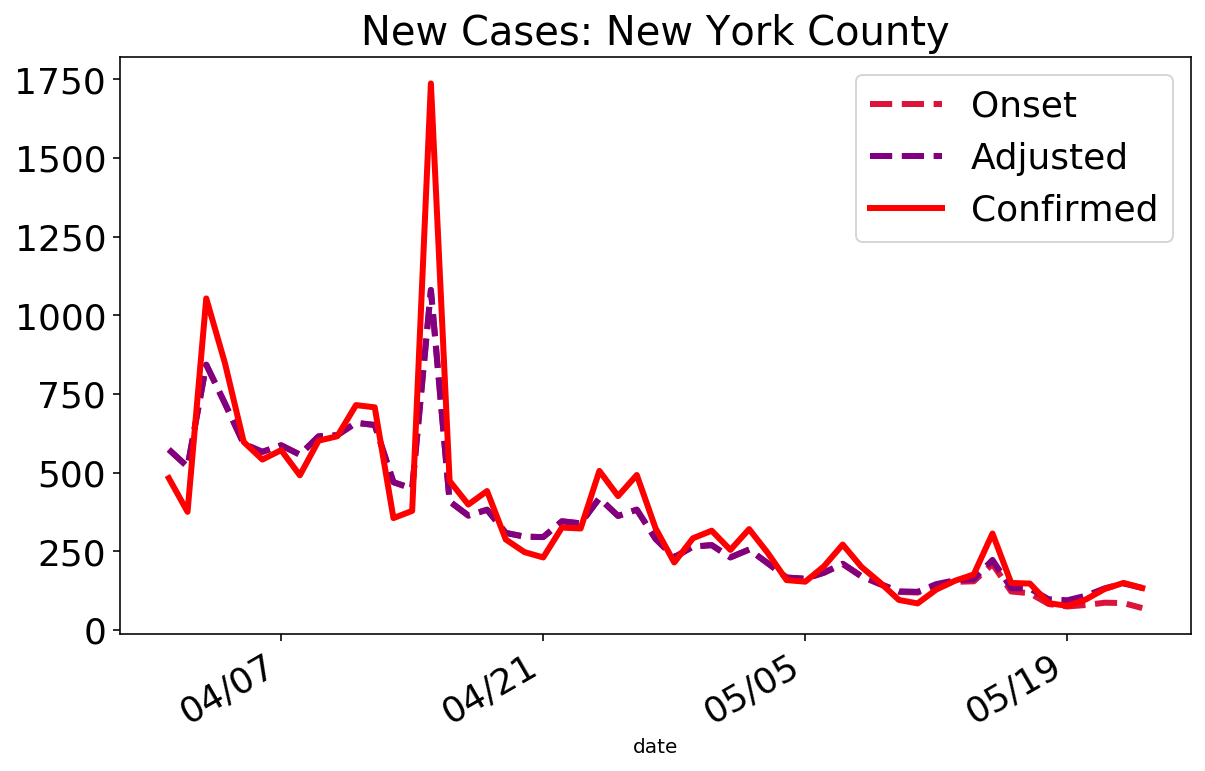

In [52]:
county =  "New York County"
county_df = ny_counties[ny_counties.county == county]
county_df = county_df.drop(["state"], axis=1)
confirmed = county_df.cases
confirmed = confirmed.loc["2020-04-01":]
onset = confirmed_to_onset(confirmed, p_delay)
onset = onset.loc["2020-04-01":]
adjusted, cumulative_p_delay = adjust_onset_for_right_censorship(onset, p_delay)
figure, plot = plt.subplots(figsize=(9, 6))
onset.plot(linestyle='--', lw=3, color='crimson', label="Onset",ax=plot, x_compat=True)
adjusted.plot(linestyle='dashed', lw=3, color='purple', label="Adjusted", ax=plot, x_compat=True)
confirmed.plot(linestyle='solid', lw=3, color='red', label="Confirmed", ax=plot, x_compat=True)
plt.legend(fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plot.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plot.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
plt.title("New Cases: " + county, fontsize=20)
plt.gcf().subplots_adjust(bottom=0.3)
plt.gcf().subplots_adjust(left=0.3)
figure.tight_layout(pad=3.0);
plt.show()
plt.close()

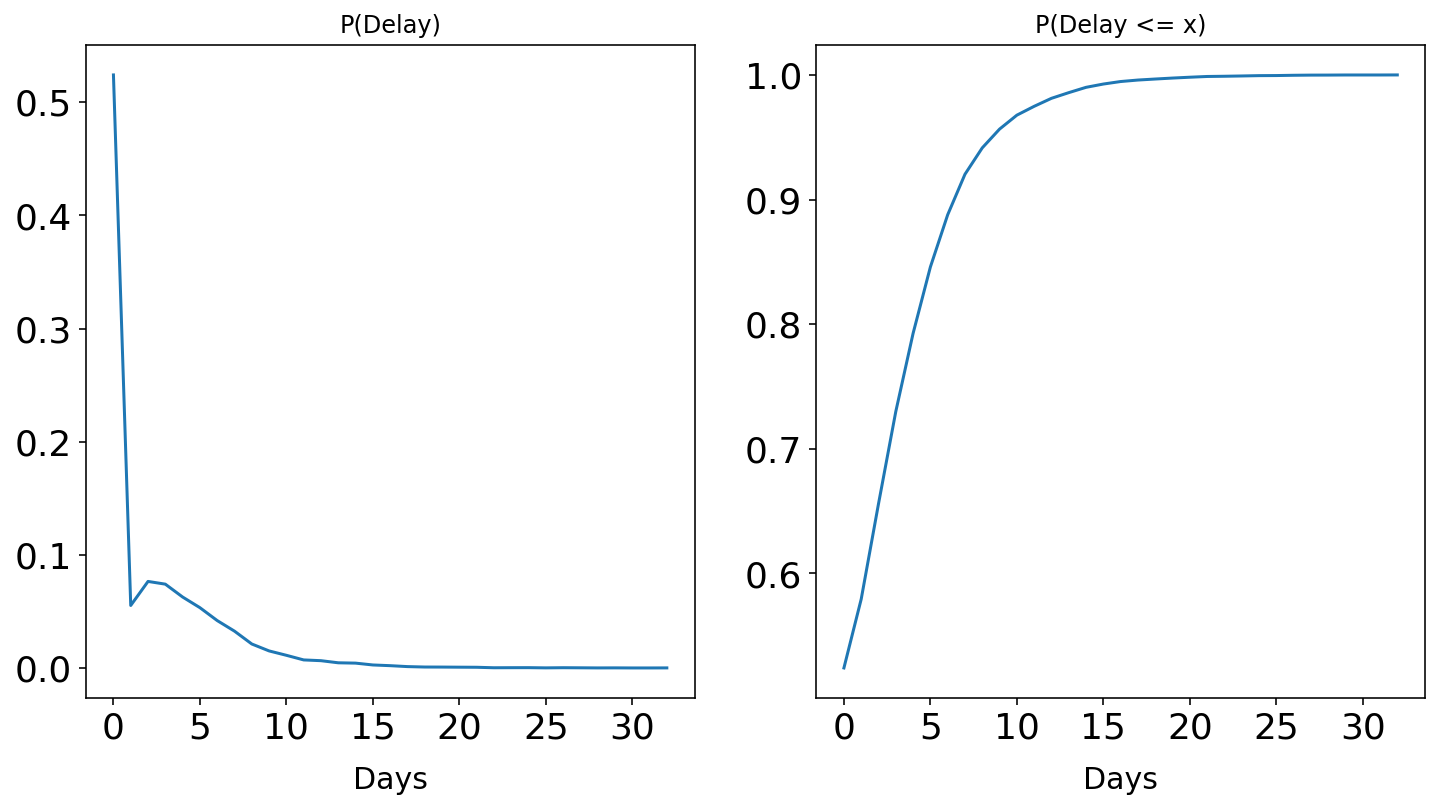

In [46]:
p_delay = get_delay_onset_confirmation_probabilities(patients)

# Show our work
fig, axes = plt.subplots(ncols=2, figsize=(12,6))
plot_a = axes[0]
plt.setp(plot_a.get_xticklabels(), fontsize=18)
plt.setp(plot_a.get_yticklabels(), fontsize=18)
p_delay.plot(title='P(Delay)', ax=plot_a)
plot_a.set_xlabel("Days", fontsize=15, labelpad=10)
    
plot_b = axes[1]
p_delay.cumsum().plot(title='P(Delay <= x)', ax=plot_b)
plt.setp(plot_b.get_xticklabels(), fontsize=18)
plt.setp(plot_b.get_yticklabels(), fontsize=18)
plot_b.set_xlabel("Days", fontsize=15, labelpad=10);

In [46]:
models = dict()

In [47]:
counties = ["Bronx County", "New York County", "Queens County", "Westchester County"]
for county in counties:
    print(county)
       
    if county in models:
        print(f'Skipping {county}, already in cache')
        continue
    
    county_df = ny_counties[ny_counties.county == county]
    county_df = county_df.loc["2020-04-01":]
    county_df = county_df.drop(["state"], axis=1)
    models[county] = create_and_run_model_for_counties(county, county_df, p_delay)


Bronx County


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [serial_interval, theta_rotated_, length_scale]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [00:35<00:00, 456.37draws/s]


New York County


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [serial_interval, theta_rotated_, length_scale]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [00:24<00:00, 659.28draws/s]


Queens County


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [serial_interval, theta_rotated_, length_scale]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [00:54<00:00, 294.20draws/s]


Westchester County


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [serial_interval, theta_rotated_, length_scale]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [00:25<00:00, 629.51draws/s]


In [45]:
reparametrize(models)

Diverging states:
New York County    1
dtype: int64


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling 4 chains, 0 divergences:  75%|███████▌  | 15000/20000 [01:22<00:27, 181.03draws/s]


In [48]:
results = aggregate_results(models)

In [49]:
results

mean    median  lower_90  upper_90  \
region             date                                                 
Bronx County       2020-04-25  0.726328  0.749198  0.519590  0.930517   
                   2020-04-26  0.709321  0.731447  0.505673  0.913483   
                   2020-04-27  0.697620  0.719009  0.491257  0.905072   
                   2020-04-28  0.691864  0.713425  0.484661  0.902345   
                   2020-04-29  0.691583  0.713267  0.484099  0.905417   
...                                 ...       ...       ...       ...   
Westchester County 2020-05-19  0.938068  0.946843  0.734715  1.122344   
                   2020-05-20  0.948233  0.955680  0.732851  1.136974   
                   2020-05-21  0.957708  0.964456  0.733038  1.156576   
                   2020-05-22  0.966186  0.971156  0.748163  1.193254   
                   2020-05-23  0.973554  0.976678  0.729438  1.198821   

                               lower_50  upper_50  
region             date                            
Bronx County       2020-04-25  0.698118  0.861911  
                   2020-04-26  0.677020  0.840143  
                   2020-04-27  0.660496  0.827585  
                   2020-04-28  0.671573  0.840668  
                   2020-04-29  0.679620  0.849936  
...                                 ...       ...  
Westchester County 2020-05-19  0.891910  1.024569  
                   2020-05-20  0.896112  1.033478  
                   2020-05-21  0.907511  1.051248  
                   2020-05-22  0.902579  1.054586  
                   2020-05-23  0.904527  1.063613  

[116 rows x 6 columns]

Bronx County
New York County
Queens County
Westchester County


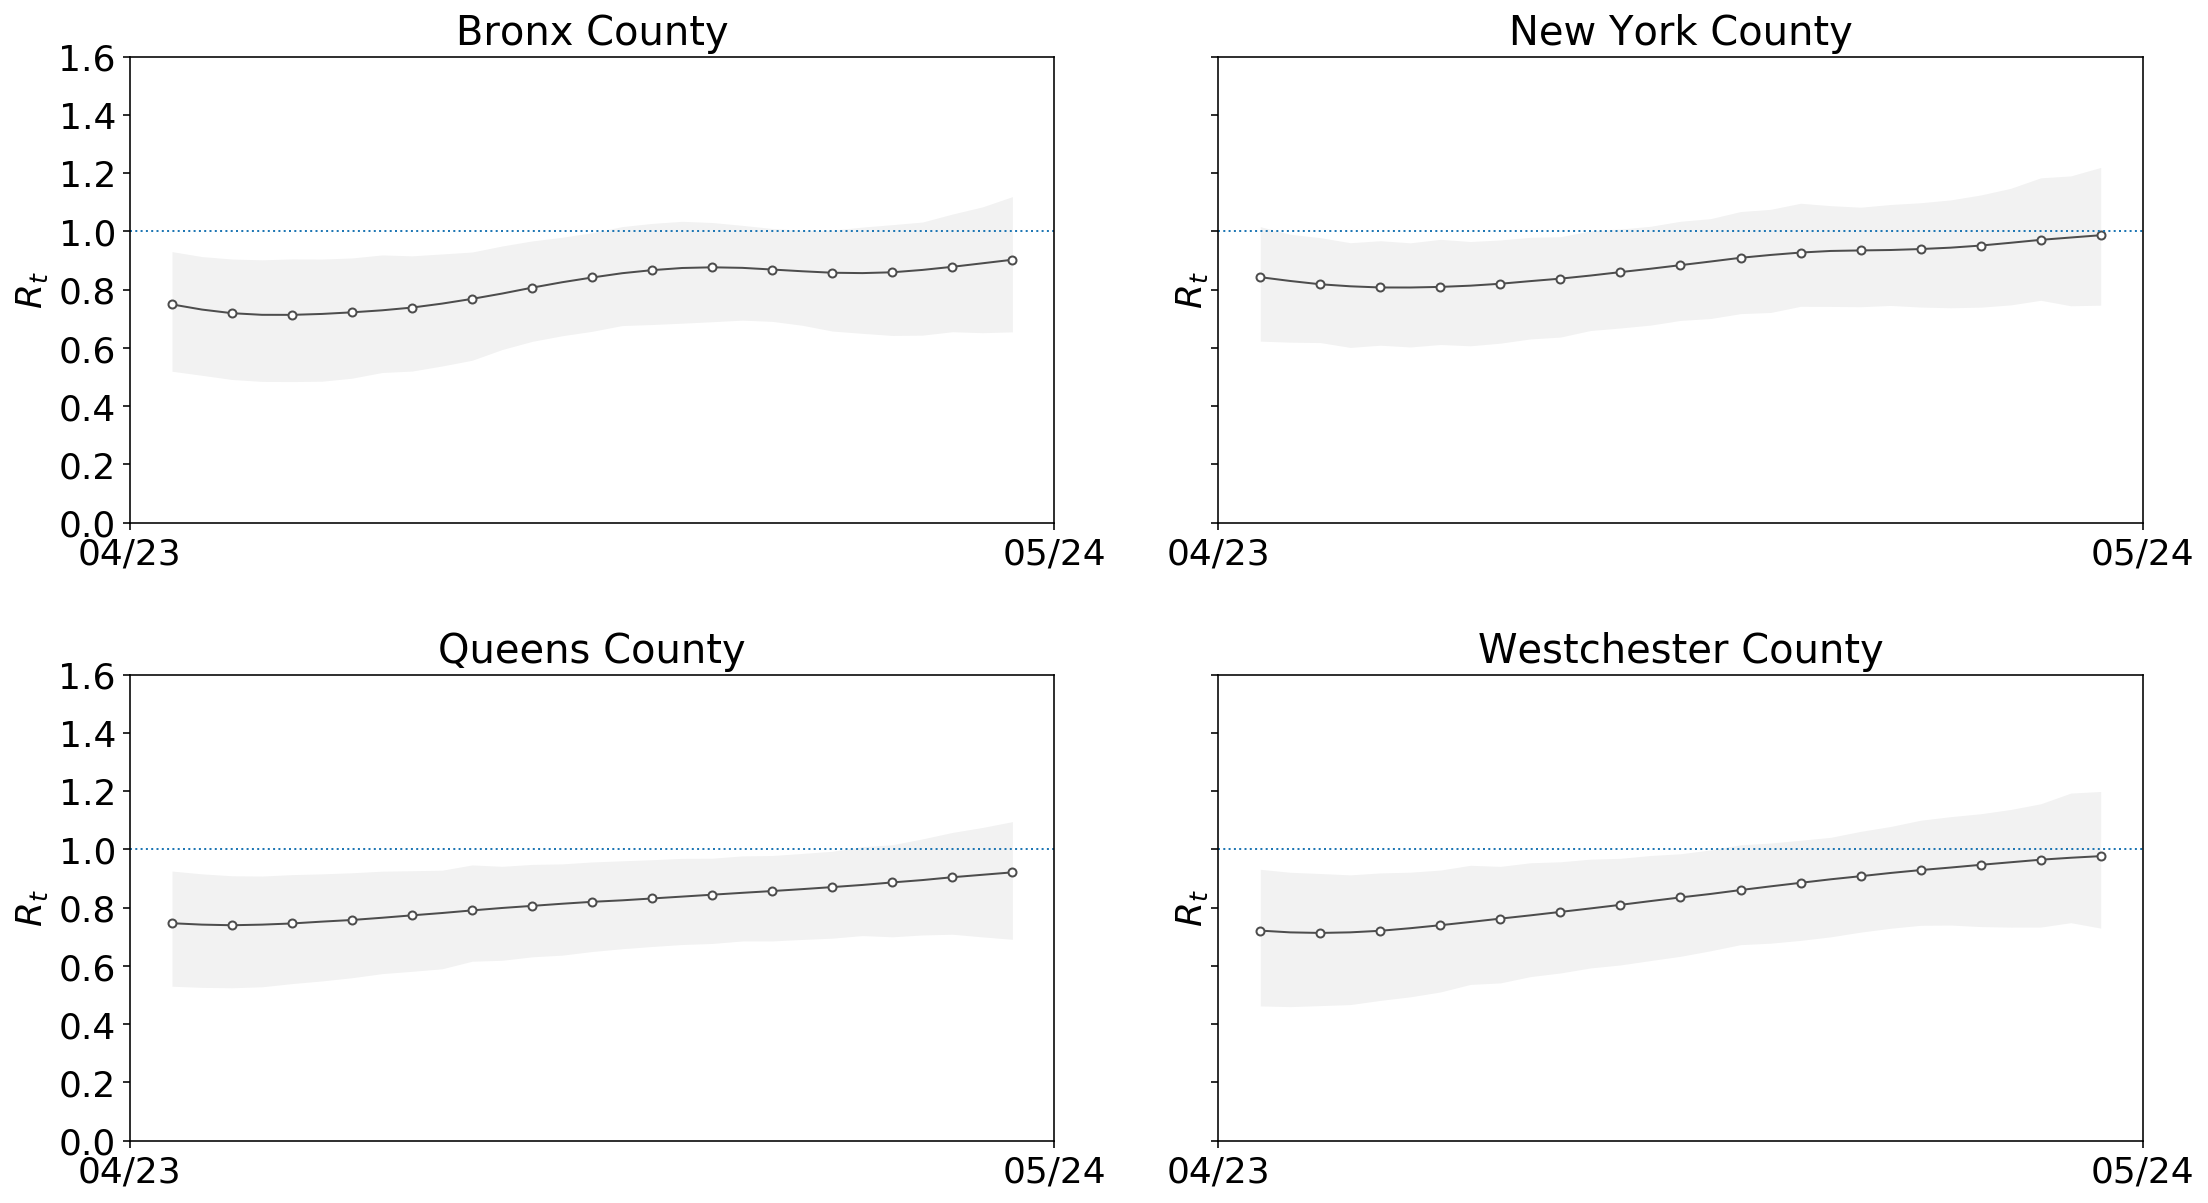

In [54]:
ncols = 2
nrows = int(np.ceil(results.index.levels[0].shape[0] / ncols))


fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(16, 9),
    sharey='row')

for ax, (region, result) in zip(axes.flat, results.groupby("region")):
    print(region)
    plot_rt(region, result.droplevel(0), ax)

fig.tight_layout(pad=3.0)
fig.set_facecolor('w')
plt.savefig("reports/rt_counties.pdf", bbox_inches="tight")
plt.show()
plt.close()